# SVM Fake News Classifier

Este notebook implementa um classificador SVM (Support Vector Machine) para detectar notícias falsas usando o dataset FakeBr News.

## Objetivo
Criar um modelo SVM que classifique notícias como verdadeiras ou falsas baseado no texto pré-processado (`preprocessed_text`).

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Carregamento dos Dados

In [5]:
# Carregar dados do parquet
df = pd.read_parquet('../data/processed/fakebr_news.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nColunas disponíveis: {df.columns.tolist()}")
print(f"\nDistribuição de classes:")
print(df['is_fake'].value_counts())
print(f"\nPorcentagem:")
print(df['is_fake'].value_counts(normalize=True) * 100)

Dataset shape: (7200, 31)

Colunas disponíveis: ['id', 'full_text', 'preprocessed_text', 'size_normalized_text', 'author', 'link', 'category', 'publication_date', 'is_fake', 'text_hash', 'created_at', 'updated_at', 'num_tokens', 'num_palavras_sem_pontuacao', 'num_tipos', 'num_links_internos', 'num_palavras_maiuscula', 'num_verbos', 'num_nomes', 'num_adjetivos', 'num_adverbios', 'num_pronomes', 'num_caracteres', 'avg_sent_length', 'avg_word_length', 'pausality', 'emotiveness', 'diversity', 'percentage_spelling_errors', 'publication_date_as_date', 'sequence']

Distribuição de classes:
is_fake
True     3600
False    3600
Name: count, dtype: int64

Porcentagem:
is_fake
True     50.0
False    50.0
Name: proportion, dtype: float64


In [6]:
# Verificar dados faltantes no preprocessed_text
print(f"Valores nulos em preprocessed_text: {df['preprocessed_text'].isnull().sum()}")
print(f"Valores vazios em preprocessed_text: {(df['preprocessed_text'] == '').sum()}")

# Remover linhas com texto vazio ou nulo
df_clean = df[df['preprocessed_text'].notna() & (df['preprocessed_text'] != '')].copy()
print(f"\nDataset após limpeza: {df_clean.shape}")

Valores nulos em preprocessed_text: 0
Valores vazios em preprocessed_text: 0

Dataset após limpeza: (7200, 31)


## 2. Análise dos Pares de Notícias

Cada notícia tem um par (1 verdadeira e 1 falsa) identificado pela coluna `sequence`.

In [7]:
# Verificar estrutura dos pares
print("Análise dos pares de notícias:")
print(f"Total de sequências únicas: {df_clean['sequence'].nunique()}")
print(f"Total de notícias: {len(df_clean)}")

# Verificar se cada sequência tem exatamente 1 verdadeira e 1 falsa
pairs_check = df_clean.groupby('sequence')['is_fake'].agg(['count', 'sum'])
pairs_check.columns = ['total', 'num_fake']
pairs_check['num_true'] = pairs_check['total'] - pairs_check['num_fake']

print(f"\nPares completos (1 verdadeira + 1 falsa): {((pairs_check['total'] == 2) & (pairs_check['num_fake'] == 1)).sum()}")
print(f"Pares incompletos: {(pairs_check['total'] != 2).sum()}")

# Mostrar exemplo de um par
sample_seq = df_clean['sequence'].iloc[0]
sample_pair = df_clean[df_clean['sequence'] == sample_seq][['sequence', 'is_fake', 'preprocessed_text', 'category']]
print(f"\nExemplo de par (sequence {sample_seq}):")
print(sample_pair)

Análise dos pares de notícias:
Total de sequências únicas: 3600
Total de notícias: 7200

Pares completos (1 verdadeira + 1 falsa): 3598
Pares incompletos: 2

Exemplo de par (sequence 5):
      sequence  is_fake                                  preprocessed_text  \
0            5     True  temer resolve problema luislinda: liberdade, a...   
3195         5    False  gustavo pedreira ferraz, admitiu buscar malas ...   

      category  
0     politica  
3195  politica  


## 3. Preparação dos Dados para Treinamento

In [8]:
# Separar features (X) e target (y)
X = df_clean['preprocessed_text'].values
y = df_clean['is_fake'].values.astype(int)  # Converter True/False para 1/0

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribuição de y:")
print(f"Fake (1): {y.sum()} ({y.sum()/len(y)*100:.2f}%)")
print(f"True (0): {len(y) - y.sum()} ({(len(y) - y.sum())/len(y)*100:.2f}%)")

Shape de X: (7200,)
Shape de y: (7200,)

Distribuição de y:
Fake (1): 3600 (50.00%)
True (0): 3600 (50.00%)


In [9]:
# Split estratificado mantendo os pares juntos
# Primeiro, vamos criar um split baseado em sequences para evitar data leakage
unique_sequences = df_clean['sequence'].unique()
train_sequences, test_sequences = train_test_split(
    unique_sequences, 
    test_size=0.2, 
    random_state=42
)

# Criar máscaras para train e test
train_mask = df_clean['sequence'].isin(train_sequences)
test_mask = df_clean['sequence'].isin(test_sequences)

X_train = df_clean[train_mask]['preprocessed_text'].values
X_test = df_clean[test_mask]['preprocessed_text'].values
y_train = df_clean[train_mask]['is_fake'].values.astype(int)
y_test = df_clean[test_mask]['is_fake'].values.astype(int)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"\nDistribuição no treino - Fake: {y_train.sum()}, True: {len(y_train) - y_train.sum()}")
print(f"Distribuição no teste - Fake: {y_test.sum()}, True: {len(y_test) - y_test.sum()}")

Tamanho do conjunto de treino: 5760
Tamanho do conjunto de teste: 1440

Distribuição no treino - Fake: 2880, True: 2880
Distribuição no teste - Fake: 720, True: 720


## 4. Vetorização do Texto (TF-IDF)

Vamos usar TF-IDF para converter o texto em features numéricas.

In [10]:
# Criar vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,  # Limitar número de features
    ngram_range=(1, 2),  # Usar unigramas e bigramas
    min_df=2,  # Palavra deve aparecer em pelo menos 2 documentos
    max_df=0.95  # Ignorar palavras que aparecem em mais de 95% dos documentos
)

# Fit e transform no conjunto de treino
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Shape de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape de X_test_tfidf: {X_test_tfidf.shape}")
print(f"\nNúmero de features: {len(tfidf.get_feature_names_out())}")

Shape de X_train_tfidf: (5760, 5000)
Shape de X_test_tfidf: (1440, 5000)

Número de features: 5000


## 5. Treinamento do Modelo SVM

### 5.1 Modelo Baseline (Linear SVM)

In [12]:
# Treinar SVM Linear (mais rápido para datasets grandes)
print("Treinando Linear SVM...")
linear_svm = LinearSVC(random_state=42, max_iter=1000)
linear_svm.fit(X_train_tfidf, y_train)

# Predições
y_pred_train = linear_svm.predict(X_train_tfidf)
y_pred_test = linear_svm.predict(X_test_tfidf)

# Avaliação
print("\n=== Resultados Linear SVM ===")
print(f"Acurácia no treino: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Acurácia no teste: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score no teste: {f1_score(y_test, y_pred_test):.4f}")

print("\nClassification Report (Teste):")
print(classification_report(y_test, y_pred_test, target_names=['True News', 'Fake News']))

Treinando Linear SVM...

=== Resultados Linear SVM ===
Acurácia no treino: 0.9988
Acurácia no teste: 0.9576
F1-Score no teste: 0.9577

Classification Report (Teste):
              precision    recall  f1-score   support

   True News       0.96      0.96      0.96       720
   Fake News       0.96      0.96      0.96       720

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



### 5.2 SVM com Kernel RBF

In [15]:
# Treinar SVM com kernel RBF (pode ser mais lento)
print("Treinando SVM com kernel RBF...")
rbf_svm = SVC(kernel='rbf', random_state=42, probability=True)
rbf_svm.fit(X_train_tfidf, y_train)

# Predições
y_pred_train_rbf = rbf_svm.predict(X_train_tfidf)
y_pred_test_rbf = rbf_svm.predict(X_test_tfidf)

# Avaliação
print("\n=== Resultados SVM RBF ===")
print(f"Acurácia no treino: {accuracy_score(y_train, y_pred_train_rbf):.4f}")
print(f"Acurácia no teste: {accuracy_score(y_test, y_pred_test_rbf):.4f}")
print(f"F1-Score no teste: {f1_score(y_test, y_pred_test_rbf):.4f}")

print("\nClassification Report (Teste):")
print(classification_report(y_test, y_pred_test_rbf, target_names=['True News', 'Fake News']))

Treinando SVM com kernel RBF...

=== Resultados SVM RBF ===
Acurácia no treino: 0.9983
Acurácia no teste: 0.9611
F1-Score no teste: 0.9613

Classification Report (Teste):
              precision    recall  f1-score   support

   True News       0.96      0.96      0.96       720
   Fake News       0.96      0.97      0.96       720

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



## 6. Otimização de Hiperparâmetros (Grid Search)

In [15]:
# Grid Search para Linear SVM
print("Executando Grid Search para Linear SVM...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge']
}

grid_search = GridSearchCV(
    LinearSVC(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

print(f"\nMelhores parâmetros: {grid_search.best_params_}")
print(f"Melhor F1-Score (CV): {grid_search.best_score_:.4f}")

# Usar o melhor modelo
best_svm = grid_search.best_estimator_

# Predições no conjunto de treino e teste
y_pred_train_best = best_svm.predict(X_train_tfidf)
y_pred_best = best_svm.predict(X_test_tfidf)

print("\n=== Resultados do Melhor Modelo ===")
print(f"Acurácia no treino: {accuracy_score(y_train, y_pred_train_best):.4f}")
print(f"Acurácia no teste: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1-Score no teste: {f1_score(y_test, y_pred_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['True News', 'Fake News']))

Executando Grid Search para Linear SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Melhores parâmetros: {'C': 1, 'loss': 'squared_hinge'}
Melhor F1-Score (CV): 0.9614

=== Resultados do Melhor Modelo ===
Acurácia no treino: 0.9988
Acurácia no teste: 0.9576
F1-Score no teste: 0.9577

Classification Report:
              precision    recall  f1-score   support

   True News       0.96      0.96      0.96       720
   Fake News       0.96      0.96      0.96       720

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



## 7. Visualização dos Resultados

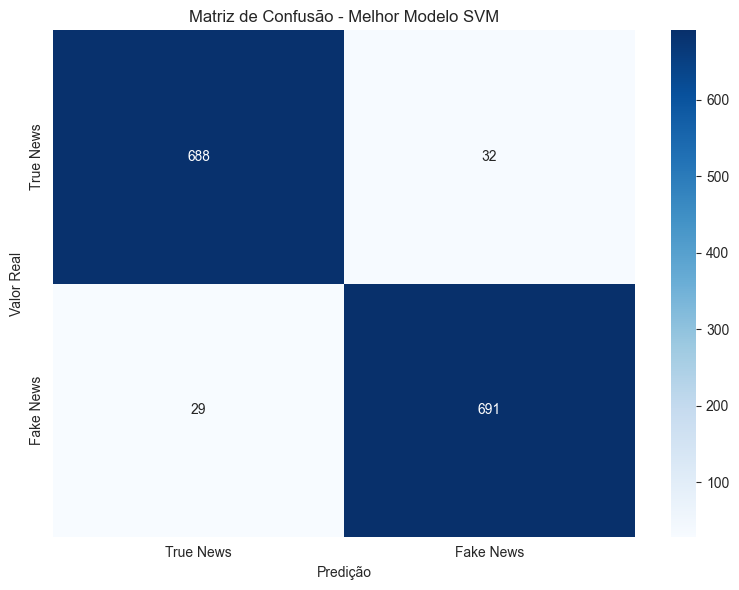


Métricas da Matriz de Confusão:
True Negatives (TN): 688
False Positives (FP): 32
False Negatives (FN): 29
True Positives (TP): 691

Precisão: 0.9557
Recall: 0.9597


In [19]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['True News', 'Fake News'],
            yticklabels=['True News', 'Fake News'])
plt.title('Matriz de Confusão - Melhor Modelo SVM')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.tight_layout()
plt.show()

# Calcular métricas da matriz de confusão
tn, fp, fn, tp = cm.ravel()
print(f"\nMétricas da Matriz de Confusão:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nPrecisão: {tp/(tp+fp):.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")


Comparação de Modelos:
                Modelo  Acurácia  F1-Score
            Linear SVM  0.957639  0.957727
               RBF SVM  0.961111  0.961272
Best SVM (Grid Search)  0.957639  0.957727


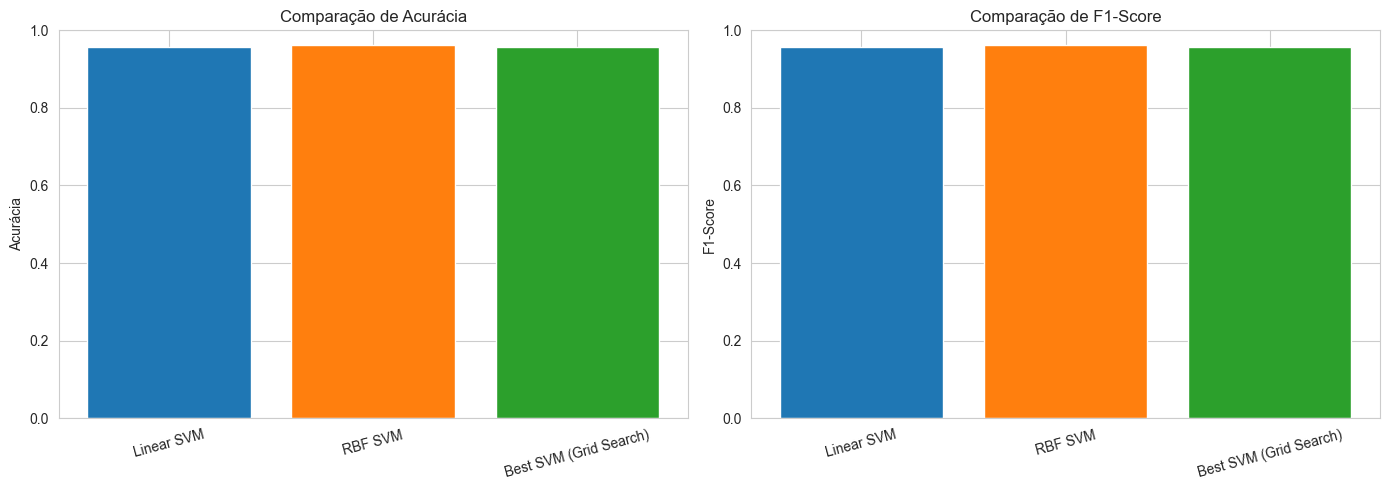

In [20]:
# Comparação de modelos
models_comparison = pd.DataFrame({
    'Modelo': ['Linear SVM', 'RBF SVM', 'Best SVM (Grid Search)'],
    'Acurácia': [
        accuracy_score(y_test, y_pred_test),
        accuracy_score(y_test, y_pred_test_rbf),
        accuracy_score(y_test, y_pred_best)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test_rbf),
        f1_score(y_test, y_pred_best)
    ]
})

print("\nComparação de Modelos:")
print(models_comparison.to_string(index=False))

# Gráfico de comparação
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Acurácia
axes[0].bar(models_comparison['Modelo'], models_comparison['Acurácia'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Comparação de Acurácia')
axes[0].set_ylabel('Acurácia')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=15)

# F1-Score
axes[1].bar(models_comparison['Modelo'], models_comparison['F1-Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_title('Comparação de F1-Score')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## 8. Análise de Features Importantes

In [21]:
# Obter coeficientes do modelo linear
feature_names = tfidf.get_feature_names_out()
coef = best_svm.coef_[0]

# Top 20 features mais importantes para FAKE news (coeficientes positivos)
top_fake_indices = np.argsort(coef)[-20:]
top_fake_features = [(feature_names[i], coef[i]) for i in top_fake_indices]

print("Top 20 Features para FAKE News:")
for feature, score in reversed(top_fake_features):
    print(f"{feature:30s}: {score:.4f}")

# Top 20 features mais importantes para TRUE news (coeficientes negativos)
top_true_indices = np.argsort(coef)[:20]
top_true_features = [(feature_names[i], coef[i]) for i in top_true_indices]

print("\nTop 20 Features para TRUE News:")
for feature, score in top_true_features:
    print(f"{feature:30s}: {score:.4f}")

Top 20 Features para FAKE News:
atraves                       : 1.7349
leia tambem                   : 1.4483
hoje                          : 1.3755
friboi                        : 1.3358
podera                        : 1.2076
dilma                         : 1.1534
reais                         : 1.0862
folha                         : 1.0685
ontem                         : 1.0502
materia                       : 0.9717
esposa                        : 0.9689
partido trabalhadores         : 0.9513
revista                       : 0.9316
senhor                        : 0.8899
advogada                      : 0.8738
alegou                        : 0.8638
publicada                     : 0.8595
mg                            : 0.8547
000                           : 0.8376
esquerda                      : 0.8184

Top 20 Features para TRUE News:
segundo                       : -3.5879
nesta                         : -3.0643
feira                         : -2.5902
afirmou                       : -2.

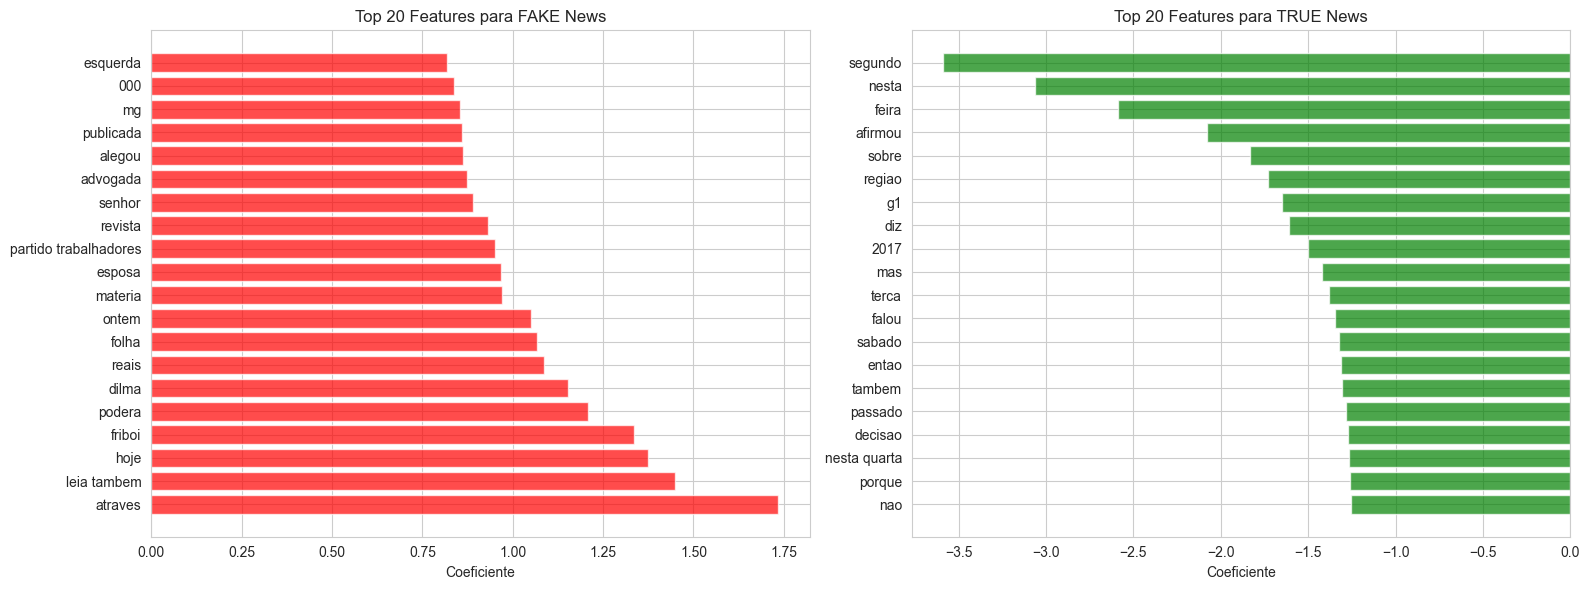

In [22]:
# Visualizar top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top features para FAKE
fake_features_df = pd.DataFrame(top_fake_features, columns=['Feature', 'Score'])
axes[0].barh(fake_features_df['Feature'], fake_features_df['Score'], color='red', alpha=0.7)
axes[0].set_title('Top 20 Features para FAKE News')
axes[0].set_xlabel('Coeficiente')
axes[0].invert_yaxis()

# Top features para TRUE
true_features_df = pd.DataFrame(top_true_features, columns=['Feature', 'Score'])
axes[1].barh(true_features_df['Feature'], true_features_df['Score'], color='green', alpha=0.7)
axes[1].set_title('Top 20 Features para TRUE News')
axes[1].set_xlabel('Coeficiente')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 9. Validação Cruzada

Executando validação cruzada (5-fold)...

F1-Scores por fold: [0.93177738 0.97902098 0.95909487 0.98360656 0.95325543]
Média: 0.9614
Desvio padrão: 0.0187


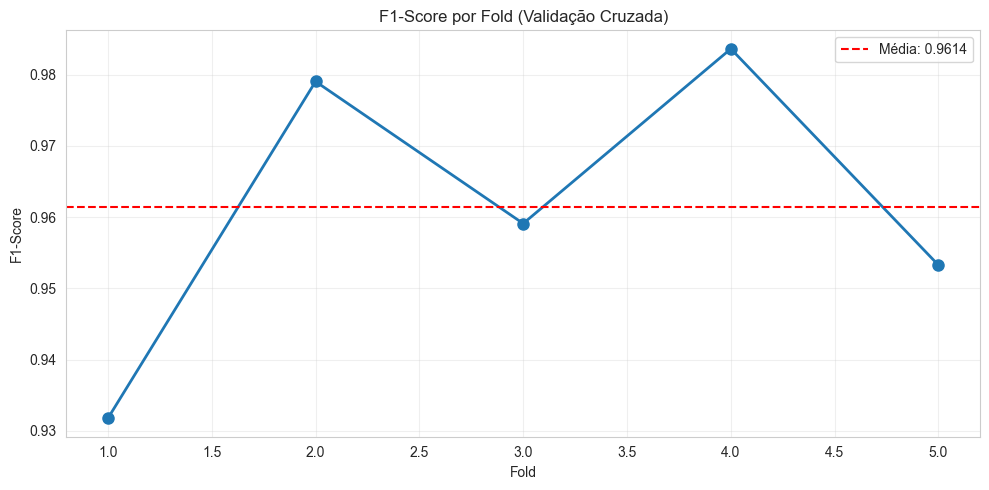

In [23]:
# Realizar validação cruzada com 5 folds
print("Executando validação cruzada (5-fold)...")
cv_scores = cross_val_score(best_svm, X_train_tfidf, y_train, cv=5, scoring='f1')

print(f"\nF1-Scores por fold: {cv_scores}")
print(f"Média: {cv_scores.mean():.4f}")
print(f"Desvio padrão: {cv_scores.std():.4f}")

# Visualizar scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Média: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('F1-Score por Fold (Validação Cruzada)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Salvar o Modelo

In [ ]:
import pickle
import os

# Criar diretório de modelos se não existir
os.makedirs('../models', exist_ok=True)

# Salvar modelo e vetorizador
with open('../models/svm_fake_news_classifier.pkl', 'wb') as f:
    pickle.dump(best_svm, f)

with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("Modelo e vetorizador salvos com sucesso!")
print("- ../models/svm_fake_news_classifier.pkl")
print("- ../models/tfidf_vectorizer.pkl")

## 11. Teste com Exemplos Reais

In [ ]:
# Função para predizer novos textos
def predict_news(text, model, vectorizer):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return "FAKE" if prediction == 1 else "TRUE"

# Testar com alguns exemplos do conjunto de teste
print("Exemplos de Predições:\n")
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    text = X_test[idx]
    real_label = "FAKE" if y_test[idx] == 1 else "TRUE"
    predicted_label = predict_news(text, best_svm, tfidf)
    
    print(f"Texto: {text[:100]}...")
    print(f"Real: {real_label} | Predição: {predicted_label}")
    print(f"Correto: {'✓' if real_label == predicted_label else '✗'}")
    print("-" * 80)
    print()

## 12. Conclusões

Este notebook implementou um classificador SVM para detectar notícias falsas usando o dataset FakeBr News.

### Principais Resultados:
- O modelo foi treinado usando texto pré-processado (`preprocessed_text`)
- Utilizamos TF-IDF para vetorização do texto
- Testamos diferentes kernels (Linear e RBF)
- Otimizamos hiperparâmetros usando Grid Search
- O modelo final foi avaliado usando validação cruzada

### Próximos Passos:
1. Testar outros algoritmos (Random Forest, Naive Bayes, etc.)
2. Experimentar com diferentes técnicas de vetorização (Word2Vec, BERT, etc.)
3. Incluir features adicionais (metadados, features linguísticas, etc.)
4. Implementar ensemble de modelos